# SARIMA Modeling
- Validation
    - Simple Train/Test Split
    - Walking Forward Validation

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta
import pickle
import math

pd.set_option('display.max_columns', None)

In [3]:
%matplotlib inline

import sys
import statsmodels as ss
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings

In [4]:
with open('berkeley_clean4.pkl','rb') as read_file:
    berkeley_df = pickle.load(read_file)

#### Building 580 will be used

In [5]:
berkeley580 = berkeley_df[berkeley_df['building_id'] == 580]

In [6]:
berkeley580

,building_id,timestamp,Date,Year,Season,Month,Day,Hour,meter_reading_scraped
377520,580,2016-01-01 00:00:00,2016-01-01,2016,Winter,1,1,0,72.0
377521,580,2016-01-01 01:00:00,2016-01-01,2016,Winter,1,1,1,74.0
377522,580,2016-01-01 02:00:00,2016-01-01,2016,Winter,1,1,2,76.0
377523,580,2016-01-01 03:00:00,2016-01-01,2016,Winter,1,1,3,73.0
377524,580,2016-01-01 04:00:00,2016-01-01,2016,Winter,1,1,4,76.0
...,...,...,...,...,...,...,...,...,...
411835,580,2019-11-30 19:00:00,2019-11-30,2019,Fall,11,30,19,48.0
411836,580,2019-11-30 20:00:00,2019-11-30,2019,Fall,11,30,20,49.0
411837,580,2019-11-30 21:00:00,2019-11-30,2019,Fall,11,30,21,48.0
411838,580,2019-11-30 22:00:00,2019-11-30,2019,Fall,11,30,22,45.0


---
### Group By Date
- ARIMA, SARIMA models will likely not be able to handle the volatility of hourly data, so meter readings will be added up by day

In [7]:
berkeley580_date = berkeley580.groupby(['Date','Year','Month']).agg({'meter_reading_scraped':'sum'}).reset_index()


In [8]:
berkeley580_date['Date2'] = berkeley580_date['Date']

In [9]:
berkeley580_date = berkeley580_date.set_index('Date2', drop = True)

In [10]:
train2 = berkeley580_date[(berkeley580_date['Date'] < pd.to_datetime('2019-11-01'))]

In [11]:
# fit SARIMA based on helper plots
sar = sm.tsa.statespace.SARIMAX(np.log(train2.meter_reading_scraped), 
                                order=(1,1,2), 
                                seasonal_order=(1,1,2,7)).fit(max_iter = 50, method = 'powell')
sar.summary()

/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.792251
         Iterations: 15
         Function evaluations: 1322


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:             meter_reading_scraped   No. Observations:                 1400
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 7)   Log Likelihood                1109.152
Date:                           Wed, 11 Dec 2019   AIC                          -2204.304
Time:                                   12:55:45   BIC                          -2167.634
Sample:                               01-01-2016   HQIC                         -2190.592
                                    - 10-31-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8372      0.015     55.695      0.000       0.808       0.867
ma.L1         -1.2216      0.023    -52.345      0.000      -1.267      -1.176
ma.L2          0.2266      0.021     10.762      0.000       0.185       0.268
ar.S.L7        0.4824      0.083      5.820      0.000       0.320       0.645
ma.S.L7       -1.2231      0.237     -5.167      0.000      -1.687      -0.759
ma.S.L14       0.2233      0.105      2.127      0.033       0.018       0.429
sigma2         0.0116      0.002      4.786      0.000       0.007       0.016
===================================================================================
Ljung-Box (Q):                       63.78   Jarque-Bera (JB):             10611.64
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                            -1.55
Prob(H) (two-sided):                  0.01   Kurtosis:                        16.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


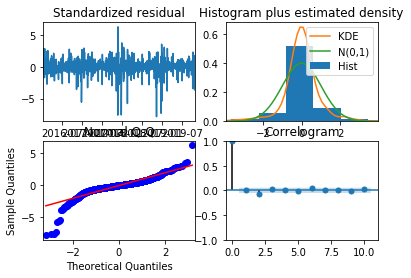

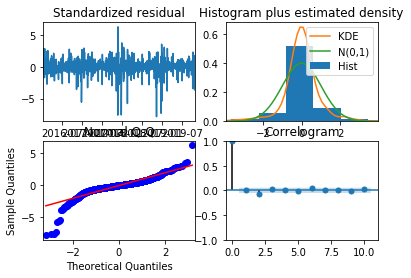

In [12]:
sar.plot_diagnostics()

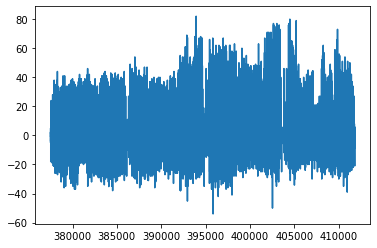

In [15]:
plt.plot(berkeley580.meter_reading_scraped.diff())

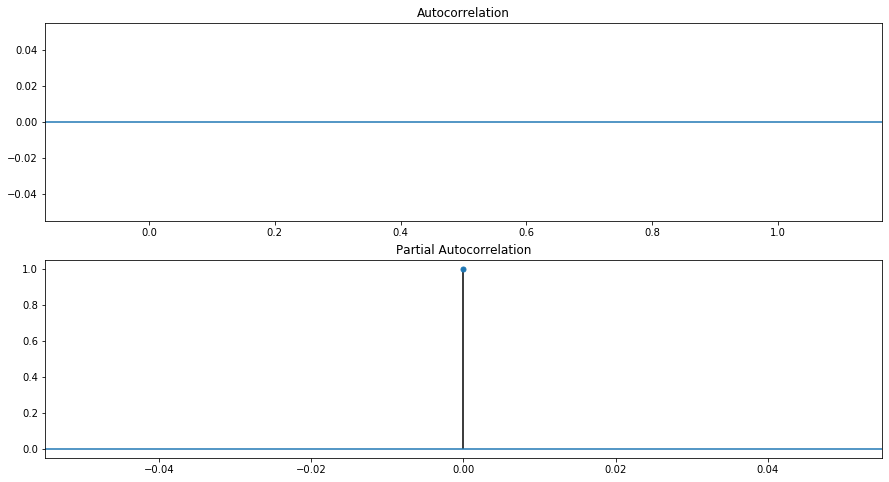

In [13]:
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(berkeley580.meter_reading_scraped.diff(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(berkeley580.meter_reading_scraped.diff(), lags=50, ax=ax[1])
plt.show()

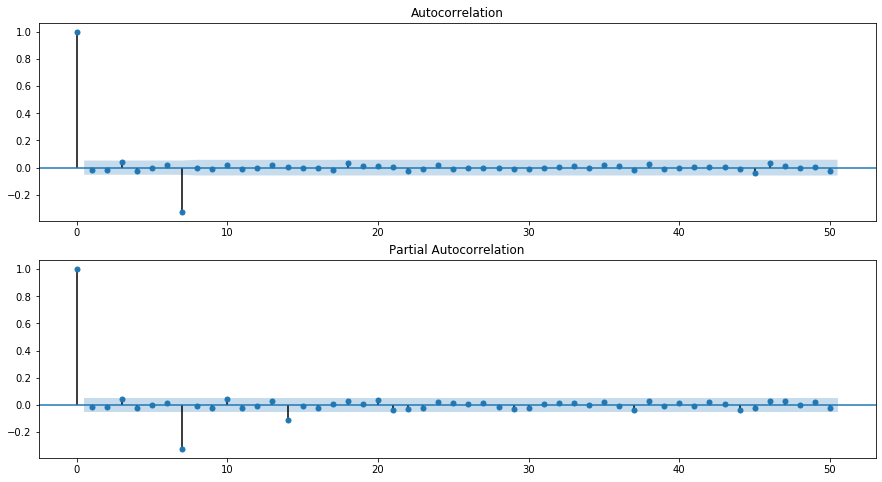

In [207]:
res = sar.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

In [208]:
from sklearn.metrics import mean_squared_error

In [224]:
log_pred = sar.predict(pd.to_datetime('2018-12-31'), pd.to_datetime('2019-11-01'))
# print('SARIMA model MSE:{}'.format(mean_squared_error(test,pred)))

In [226]:
def unlog_pred(log_pred):
    
#     log_pred = model.get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=False)
#     pred_ci = log_pred.conf_int()
    
#     log_pred = log_pred.predicted_mean
    
    pred = [math.exp(i) for i in log_pred.values]
    pred = pd.Series(pred, index = log_pred.index)
    
#     pred_ci.columns = [['lower_meter_reading_scraped', 'upper_meter_reading_scraped']]
    
#     lower_pred_ci = [math.exp(i) for i in pred_ci['lower meter_reading_scraped'].values]
#     upper_pred_ci = [math.exp(i) for i in pred_ci['upper meter_reading_scraped'].values]
    
#     pred_ci['lower meter_reading_scraped'] = lower_pred_ci
#     pred_ci['upper meter_reading_scraped'] = upper_pred_ci
    
    return pred

In [227]:
sar_pred = unlog_pred(log_pred)

### Plotting

In [228]:
berkeley580_plot = pd.DataFrame(berkeley580_date['meter_reading_scraped'])

In [229]:
berkeley580_plot

,meter_reading_scraped
Date2,
2016-01-01,1772.0
2016-01-02,1337.0
2016-01-03,1284.0
2016-01-04,2017.0
2016-01-05,1933.0
...,...
2019-11-26,2460.0
2019-11-27,2060.0
2019-11-28,1749.0


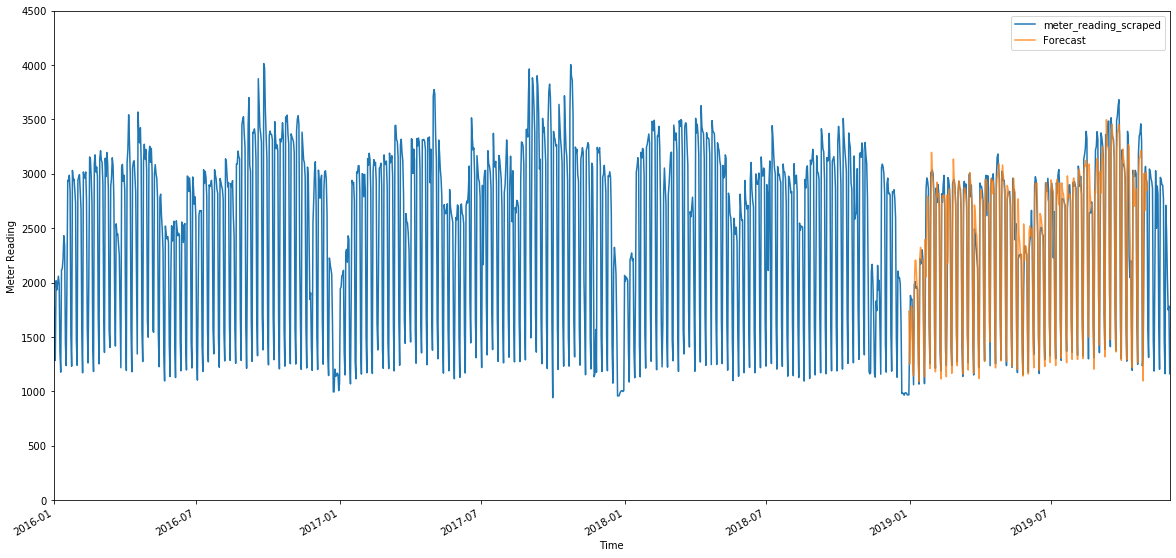

In [230]:
# plot predictions

ax = berkeley580_plot.plot(label='Observed Meter Readings', figsize=(20,10))
sar_pred.plot(ax=ax, label='Forecast', alpha=.8) # this is using all available info

# ax.fill_between(sar_pred_ci.index, sar_pred_ci.iloc[:, 0], sar_pred_ci.iloc[:, 1], color='k', alpha=.1)

# ax.set_xlim(dt.date(2019, 1, 1), dt.date(2019, 11, 30))
ax.set_ylim(0, 4500)
ax.set_xlabel('Time')
ax.set_ylabel('Meter Reading')
plt.legend()

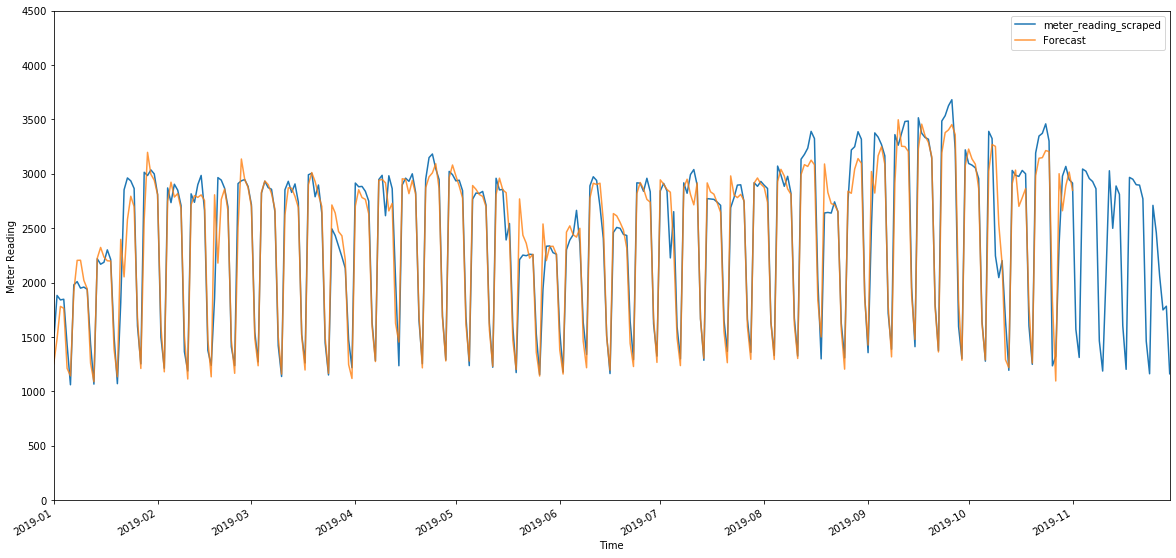

In [231]:
# plot predictions

ax = berkeley580_plot.plot(label='Observed Meter Readings', figsize=(20,10))
sar_pred.plot(ax=ax, label='Forecast', alpha=.8) # this is using all available info

# ax.fill_between(sar_pred_ci.index, sar_pred_ci.iloc[:, 0], sar_pred_ci.iloc[:, 1], color='k', alpha=.1)

ax.set_xlim(dt.date(2019, 1, 1), dt.date(2019, 11, 30))
ax.set_ylim(0, 4500)
ax.set_xlabel('Time')
ax.set_ylabel('Meter Reading')
plt.legend()

In [232]:
pred_forecast_log = sar.get_forecast(steps = 30)
pred_forecast = unlog_pred(pred_forecast_log.predicted_mean)

In [233]:
pred_forecast = unlog_pred(pred_forecast_log.predicted_mean)

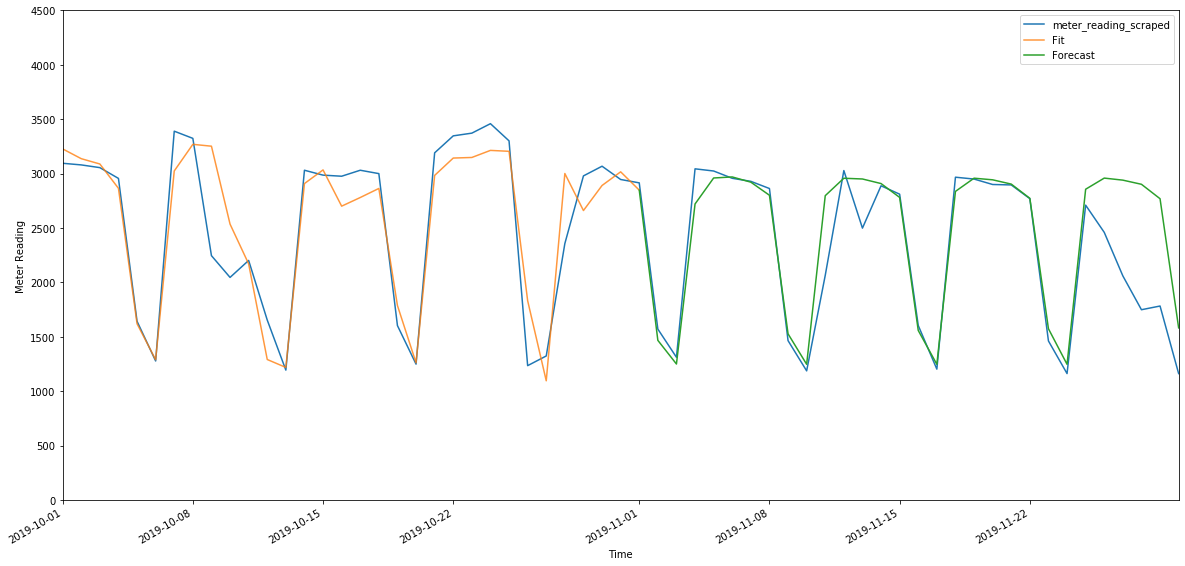

In [234]:
# plot predictions

ax = berkeley580_plot.plot(label='Observed Meter Readings', figsize=(20,10))
sar_pred.plot(ax=ax, label='Fit', alpha=.8) # this is using all available info
pred_forecast.plot(ax = ax, label='Forecast')

# ax.fill_between(sar_pred_ci.index, sar_pred_ci.iloc[:, 0], sar_pred_ci.iloc[:, 1], color='k', alpha=.1)

ax.set_xlim(dt.date(2019, 10, 1), dt.date(2019, 11, 30))
ax.set_ylim(0, 4500)
ax.set_xlabel('Time')
ax.set_ylabel('Meter Reading')
plt.legend()

### Evaluation

In [236]:
# compute mean square error
fcast = pred_forecast.values
true = berkeley580_plot[dt.date(2019, 11, 1):]['meter_reading_scraped'].values

mse_score = ((fcast - true) ** 2).mean()
print('MSE of our forecasts is {}'.format(round(mse_score, 3)))

MSE of our forecasts is 148379.529


In [237]:
rmse = math.sqrt(mse_score)
rmse

385.2006349563868

In [238]:
rmse/true.mean()

0.16895752746785783

In [239]:
from sklearn.metrics import mean_absolute_error

In [244]:
mae = (abs(fcast-true)/true)*100

In [249]:
mae.mean()

11.665957360578338

In [250]:
# create and run statistical tests on model
norm_val, norm_p, skew, kurtosis = sar.test_normality('jarquebera')[0]
lb_val, lb_p = sar.test_serial_correlation(method='ljungbox')[0]
het_val, het_p = sar.test_heteroskedasticity('breakvar')[0]

# we want to look at largest lag for Ljung-Box, so take largest number in series
# there's intelligence in the method to determine how many lags back to calculate this stat
lb_val = lb_val[-1]
lb_p = lb_p[-1]
durbin_watson = sm.stats.stattools.durbin_watson(sar.filter_results.standardized_forecasts_error[0, sar.loglikelihood_burn:])

print('Normality: val={:.3f}, p={:.3f}'.format(norm_val, norm_p));
print('Ljung-Box: val={:.3f}, p={:.3f}'.format(lb_val, lb_p));
print('Heteroskedasticity: val={:.3f}, p={:.3f}'.format(het_val, het_p));
print('Durbin-Watson: d={:.2f}'.format(durbin_watson))

Normality: val=10611.644, p=0.000
Ljung-Box: val=63.785, p=0.010
Heteroskedasticity: val=1.267, p=0.011
Durbin-Watson: d=1.97


## Walk Forward Validation

In [243]:
X = np.log(berkeley580_date.meter_reading_scraped.values)
time = berkeley580_date.index

In [268]:
train2

,Date,Year,Month,meter_reading_scraped
Date2,,,,
2016-01-01,2016-01-01,2016,1,1772.0
2016-01-02,2016-01-02,2016,1,1337.0
2016-01-03,2016-01-03,2016,1,1284.0
2016-01-04,2016-01-04,2016,1,2017.0
2016-01-05,2016-01-05,2016,1,1933.0
...,...,...,...,...
2019-10-27,2019-10-27,2019,10,1324.0
2019-10-28,2019-10-28,2019,10,2357.0
2019-10-29,2019-10-29,2019,10,2979.0


In [31]:
def train_test_split(data, n_test):
    return data[:n_test], data[n_test:]

In [252]:
train, test = train_test_split(X, 1400)

In [356]:
test

array([7.9776251 , 7.35946764, 7.17930797, 8.02092772, 8.01433574,
       7.99193052, 7.98241635, 7.95962531, 7.28961052, 7.07918439,
       7.63288551, 8.01565761, 7.82364593, 7.9683195 , 7.94129557,
       7.38025579, 7.09257372, 7.99530662, 7.98956045, 7.97246602,
       7.97108575, 7.9266026 , 7.28756064, 7.05789794, 7.90470391,
       7.80791663, 7.63046126, 7.46679948, 7.48605262, 7.05789794])

In [36]:
time[0]

datetime.date(2016, 1, 1)

Prediction for:
- Month of November

In [351]:
test[7:14]

array([7.95962531, 7.28961052, 7.07918439, 7.63288551, 8.01565761,
       7.82364593, 7.9683195 ])

In [304]:
walk_index = list(train2.Date.values)

In [367]:
X = np.log(berkeley580_date.meter_reading_scraped.values)
# walk forward validation in a step by step manner
def walk_forward_validation(data, n_test, end_date):
    predictions = []
    mae_list = []
    first_index = list(train2.Date.values)
    train, test = train_test_split(data, n_test)
    history = [x for x in train] #seed history with training data
    i_list = [7,14,21,28]
    for index, i in enumerate(i_list):  
        
        j = i-7
        model = sm.tsa.statespace.SARIMAX(pd.Series(history, index = first_index), order=(1,1,2), 
                                                    seasonal_order=(1,1,2,7)).fit(max_iter = 50, method = 'powell')
        
        log_pred = model.predict(pd.to_datetime('2018-12-31'), pd.to_datetime(end_date))
        sar_pred = unlog_pred(log_pred)
        
        pred_forecast_log = model.get_forecast(steps = 7)
        pred_forecast = unlog_pred(pred_forecast_log.predicted_mean)
        predictions = np.concatenate((predictions, pred_forecast), axis=None)
        
        mae_test = np.array([math.exp(num) for num in test[j:i]])
        mae_score = (abs(mae_test-predictions[j:i])/mae_test)*100
        mae_mean = mae_score.mean()
        print(mae_mean)
        mae_list.append(mae_mean)
        print('-------------------')
                                          
        history = np.concatenate((history, test[j:i]), axis=None) #add it to history for next loop
        end_date = pd.to_datetime(end_date) + timedelta(days=7)
        
        i = 0
        for i in range(7):
            add_day = [first_index[-1] + timedelta(days=1)]
            first_index.extend(add_day)
            i += 1
    
    mae = np.array(mae_list).mean()

    return predictions, mae

walk_pred, walk_mae = walk_forward_validation(X, 1400, '2019-11-01')

In [362]:
walk_pred, walk_mae = walk_forward_validation(X, 1400, '2019-11-01')

First_Index: 2016-01-01
Last_Index: 2019-10-31
History Length: 1400


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.792251
         Iterations: 15
         Function evaluations: 1322
End Date: 2019-11-01
-------------------
3.858425840785915
First_Index: 2016-01-01
Last_Index: 2019-11-07
History Length: 1407


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.794589
         Iterations: 15
         Function evaluations: 1350
End Date: 2019-11-08 00:00:00
-------------------
10.366336464405785
First_Index: 2016-01-01
Last_Index: 2019-11-14
History Length: 1414


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.792110
         Iterations: 16
         Function evaluations: 1448
End Date: 2019-11-15 00:00:00
-------------------
4.434424562006792
First_Index: 2016-01-01
Last_Index: 2019-11-21
History Length: 1421


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.793819
         Iterations: 15
         Function evaluations: 1375
End Date: 2019-11-22 00:00:00
-------------------
20.309806520571385


In [366]:
np.array(walk_mae).mean()

9.74224834694247

In [44]:
# def unlog(list_of_series):
    
#     unlog_list = []
#     unlog_dict = {}
    
#     for enum, series in enumerate(list_of_series):
#         unlog_list = []
#         for index, values in series.iteritems():
#             unlog_list.append(math.exp(values))
#             unlog_dict[enum] = unlog_list
#         continue
   
#     return unlog_dict

In [335]:
pred_index = [pd.to_datetime('2019-11-01')]
add_day = pd.to_datetime('2019-11-01')
i = 0
for i in range(28):
    add_day += timedelta(days=1)
    add_day_list = [add_day]
    pred_index.extend(add_day_list)
    i += 1


In [339]:
total_preds = []

for i in range(4):
    for num in walk_pred[i]:
        total_preds.append(num)
    

In [340]:
len(total_preds)

28

(0, 5000)

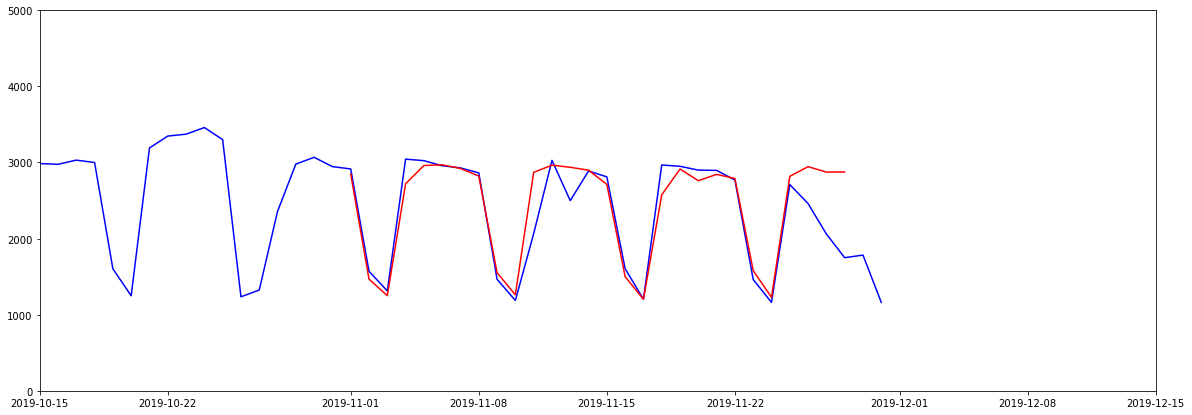

In [341]:
plt.figure(figsize=[20,7])
plt.plot(berkeley580_plot, 'b')
plt.plot(pred_index[:-1], total_preds, 'r')
plt.xlim(dt.datetime(2019,10,15), dt.datetime(2019,12,15))
plt.ylim(0, 5000)

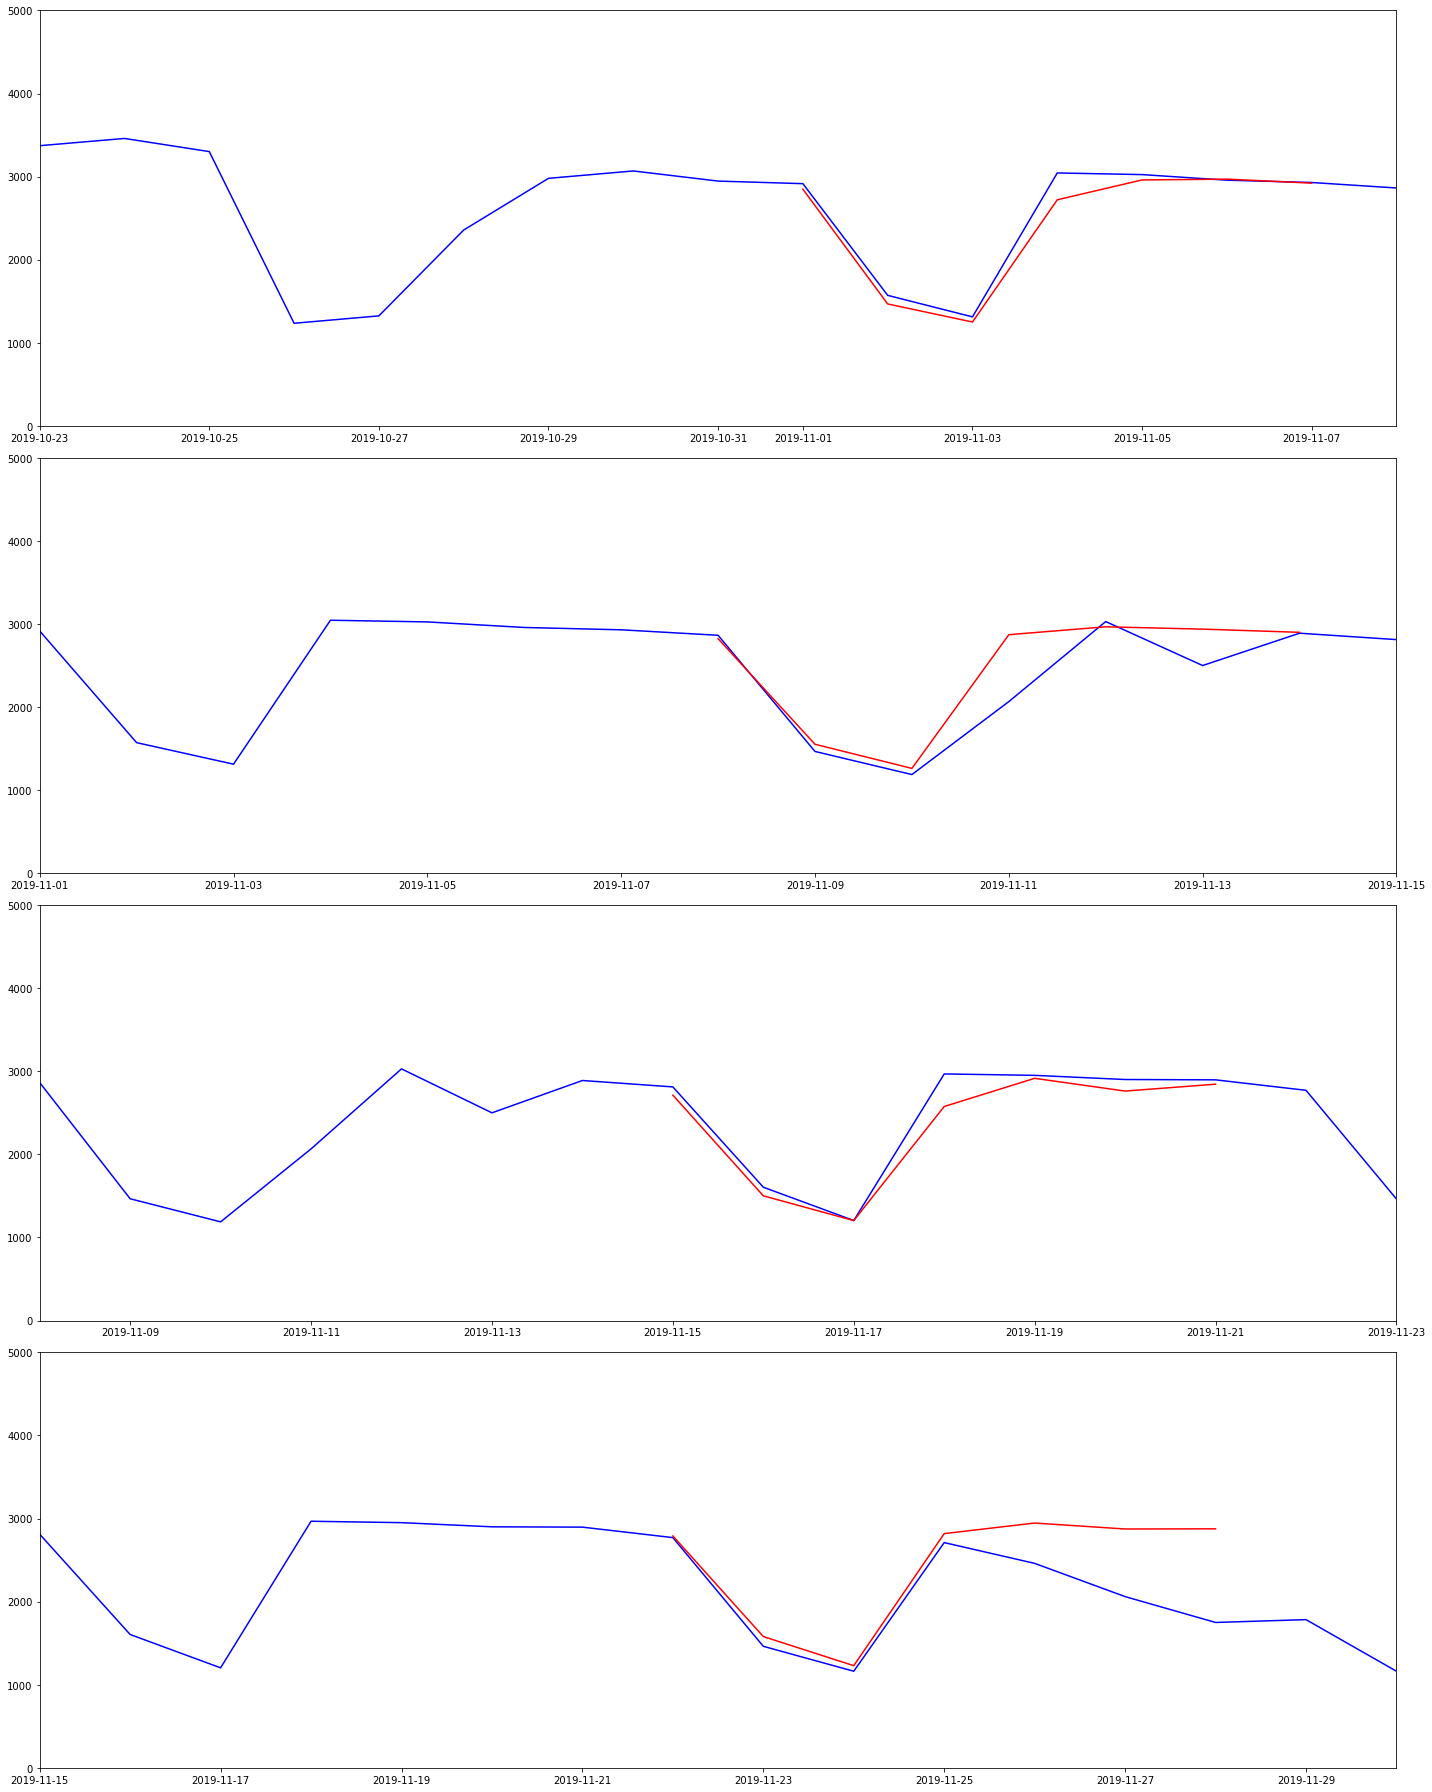

In [344]:
plt.figure(figsize=[20,25])
plt.title('Walk Forward Validation', fontsize=20)

plt.subplot(4,1,1)
plt.plot(berkeley580_plot, 'b')
plt.plot(walk_pred[0], 'r')
plt.xlim(dt.datetime(2019,10,23), dt.datetime(2019,11,8))
plt.ylim(0, 5000)

plt.subplot(4,1,2)
plt.plot(berkeley580_plot, 'b')
plt.plot(walk_pred[1], 'r')
plt.xlim(dt.datetime(2019,11,1), dt.datetime(2019,11,15))
plt.ylim(0, 5000)

plt.subplot(4,1,3)
plt.plot(berkeley580_plot, 'b')
plt.plot(walk_pred[2], 'r')
plt.xlim(dt.datetime(2019,11,8), dt.datetime(2019,11,23))
plt.ylim(0, 5000)

plt.subplot(4,1,4)
plt.plot(berkeley580_plot, 'b')
plt.plot(walk_pred[3], 'r')
plt.xlim(dt.datetime(2019,11,15), dt.datetime(2019,11,30))
plt.ylim(0, 5000)

plt.tight_layout()

In [ ]:
# # walk forward validation in a step by step manner
# def walk_forward_validation(data, n_test):
#     predictions = []
#     train, test = train_test_split(data, n_test)
#     history = np.concatenate((train,test[:185]), axis=None) #seed history with training data
#     i_list = [367,549,731,913,1095,1277]
#       # walk forward
#     for index, i in enumerate(i_list):
#         print('index:', index)
#         if index < 5:
#             delta = 182
#         else:
#             delta = 150
#         print('delta:', delta)
#         print('i:', i)
#         j = i - delta
#         print('j:', j)
#         print('Length of history', len(history))
#         print('len(history)-delta:', len(history)-delta)
#         # fit model and make forecast for history
#         model = sm.tsa.statespace.SARIMAX(pd.Series(history, index = time[:len(history)]), 
#                                 order=(1,1,2), 
#                                 seasonal_order=(1,1,2,7)).fit(max_iter = 50, method = 'powell')

#         log_pred = model.get_prediction(start=time[len(history)-delta], dynamic=False) # predict 367 to 549
#         log_pred = log_pred.predicted_mean
        
#         print('Length of log_pred:', len(log_pred))
#         print('---------')
#         predictions.append(log_pred)
# #         predictions.extend(y) #store the forecast
#         history = np.concatenate((history, test[j:i]), axis=None) #add it to history for next loop
#     # estimate error
# #     error = measure_rmse(test, predictions)
# #     print(' > %.3f' % error)
#     return history, predictions